# Exploration 10. 인공지능으로 세상에 없던 새로운 패션 만들기 🎀

## 생성적 적대 신경망(GANs)이란?
생성적 적대 신경망 (Generative Adversarial Networks, GANs)은 요즘 컴퓨터 과학에서 가장 흥미로운 아이디어 중 하나입니다. 두개의 모델이 적대적인 과정을 통해 동시에 훈련됩니다. 생성자 ("예술가")는 진짜처럼 보이는 이미지를 생성하도록 배우는 와중에, 감별자 ("예술비평가")는 가짜의 이미지로부터 진짜를 구별하게 되는 것을 배우게 됩니다.

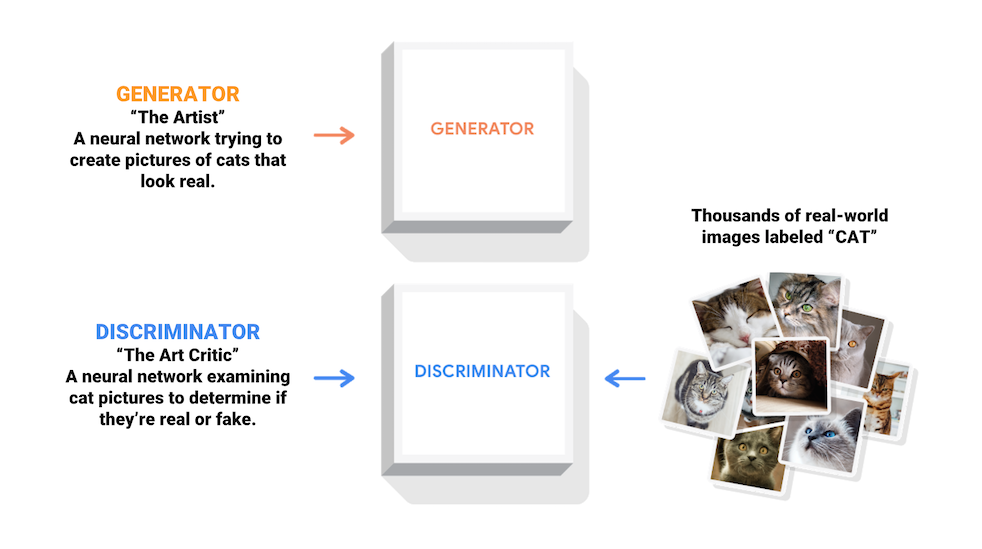

훈련과정 동안 생성자는 점차 실제같은 이미지를 더 잘 생성하게 되고, 감별자는 점차 진짜와 가짜를 더 잘 구별하게됩니다. 이 과정은 감별자가 가짜 이미지에서 진짜 이미지를 더이상 구별하지 못하게 될때, 평형상태에 도달하게 됩니다.

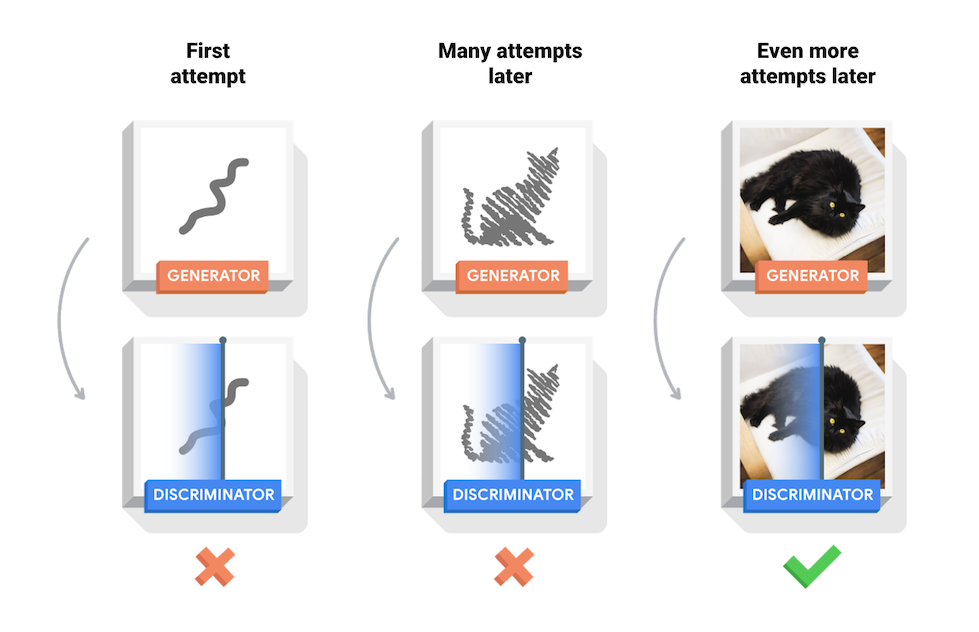

출처: https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko

# CIFAR-10 이미지 생성하기
🎀 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려
🎀 노드에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델 직접 만들기

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

## STEP 1. 작업환경 구성하기

In [54]:
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

## STEP 2. 데이터셋 구성하기
- CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋 구성 가능

>학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.  
로드한 학습 데이터를 시각화를 통해 확인해 봅시다.  
tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [66]:
# 필요한 라이브러리
import os
import glob
import time
import PIL
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

from IPython import display
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [68]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


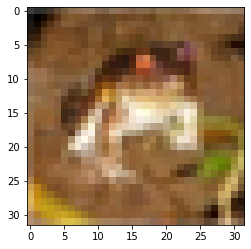

In [69]:
plt.imshow(train_x[0])
plt.show()

#### - 정규화

In [70]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


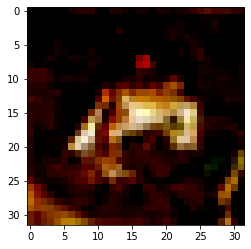

In [71]:
plt.imshow(train_x[0])
plt.show()

### 🎀 `imshow()` 함수
> - 컬러 이미지의 경우 [0, 1] or [0, 255] 범위만 제대로 인식
> -[-1, 1]로 변형한 이미지를 다시 1을 더하고 2로 나누어 [0, 1] 사이로 변형하여 원본대로 출력.

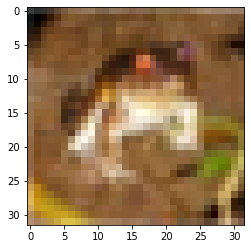

In [72]:
plt.imshow((train_x[0] + 1) / 2.0)
plt.show()

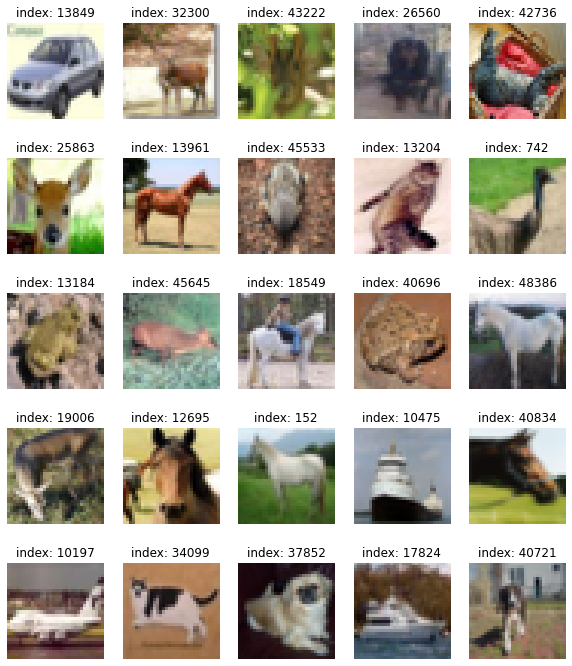

In [73]:
# train image 랜덤으로 설정
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index]+1)/2.0)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [74]:
BUFFER_SIZE = 50000 # 전체 데이터 섞기 (데이터 사이즈와 같게(or 크게) 설정)
BATCH_SIZE = 256 # minibatch 한 번에 학습할 데이터의 양 

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

## 🎀 `my_load_data` 사용
- 라벨을 입력하면, 해당 라벨을 가지고 있는 데이터를 추출 및 변환하여 주는 함수
- 특별히 시험 데이터를 사용하지 않기 때문에 훈련 데이터와 시험 데이터를 결합하여 사용

In [64]:
## 데이터 로드
def my_load_data(label = None):
    cifar10 = tf.keras.datasets.cifar10
    (train_x, train_y), (test_x, test_y) = cifar10.load_data()
    
    # 특정 라벨 데이터 추출
    if label:
        # 훈련 데이터 이미지
        df = pd.DataFrame(list(zip(train_x, train_y)), columns = ['img', 'class'])
        df = df[df['class'] == label]
        train_x = np.array([i for i in list(df['img'])])
        
        # 시험 데이터 이미지
        df = pd.DataFrame(list(zip(train_x, train_y)), columns = ['img', 'class'])
        df = df[df['class'] == label]
        test_x = np.array([i for i in list(df['img'])])
        
        x = np.concatenate((train_x, test_x)) # 훈련 데이터, 시험 데이터 결합
        x = (x - 127.5) / 127.5 # (-1, 1) 값으로 정규화
    
    return x

#### - 새 이미지

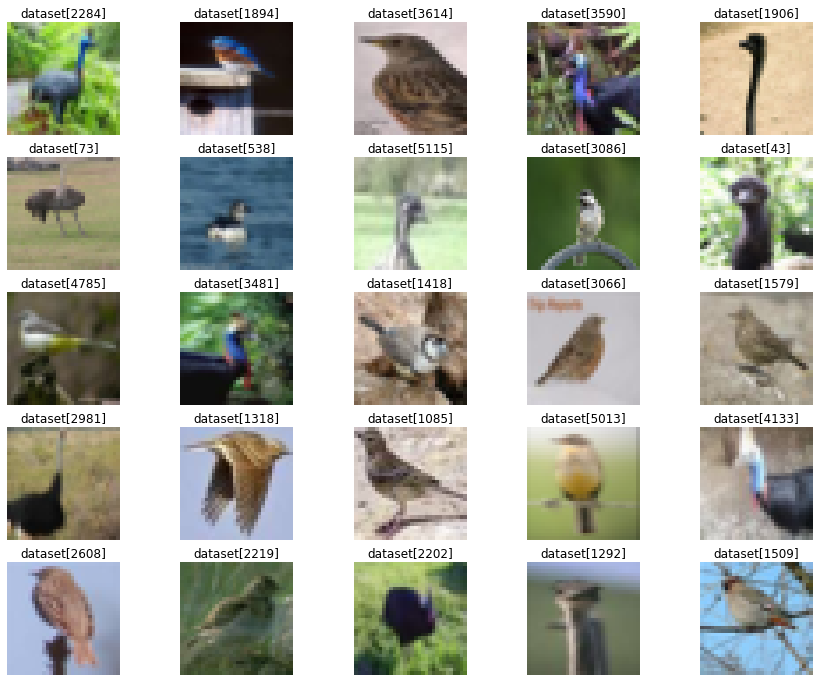

In [65]:
dataset = my_load_data(2) # label = 2 (bird)

# 미리보기
plt.figure(figsize = (15, 12))

for i in range(25):
    idx = np.random.randint(dataset.shape[0])
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.array(dataset[i] * 127.5 + 127.5).astype('uint8'))
    plt.title(f'dataset[{idx}]')
    plt.axis('off')
plt.show()

## Step 3. 생성자 모델 구현하기
> (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.  
noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.  
생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [75]:
def make_generator_model():
    model = tf.keras.Sequential()

    # 1: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 2: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))

    # 3: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 4: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 5: Conv2DTranspose layer    
    model.add(layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    # 6: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

#### - 랜덤 이미지 생성하기

In [76]:
noise = tf.random.normal([1, 100])

In [77]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)        

In [78]:
generated_image = generator(noise, training=False)  # 훈련 중이 아니므로 training=False
generated_image.shape

TensorShape([1, 32, 32, 3])

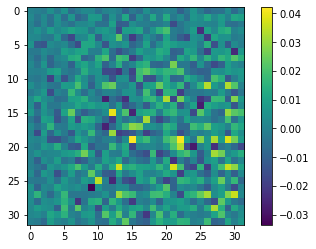

In [79]:
# matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0, 3번째 인덱스는 0으로 설정
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현하기

In [80]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # 1: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5),  strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 2: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 3: Conv2D Layer
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 4: Flatten Layer
    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 5: Flatten Layer    
    model.add(layers.Flatten())

    # 6: Dense Layer
    model.add(layers.Dense(1))

    return model

In [81]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)        

In [82]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00081608]], dtype=float32)>

## STEP 5. 손실함수와 최적화 함수 구현하기

In [83]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [84]:
# fake_output이 1에 가까울수록 (What generator wants) 작은 값을 가진다.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [85]:
# real은 1에, fake는 0에 가깝길 원함.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

In [86]:
# 판별자 정확도 판별 - 둘 다 0.5에 가까운 것이 이상적이다.
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    
    return real_accuracy, fake_accuracy

In [87]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(2e-4, 0.5)

In [88]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기
>1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.  
16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.  
훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.  
training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [89]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [90]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0])
        plt.imshow((predictions[i] + 1) / 2.0) # 역정규화를 하여 이미지를 출력
        plt.axis('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [91]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [92]:
# training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기
> 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.  
학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.  
학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [93]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [94]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

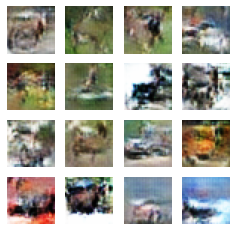

Time for training : 1231 sec


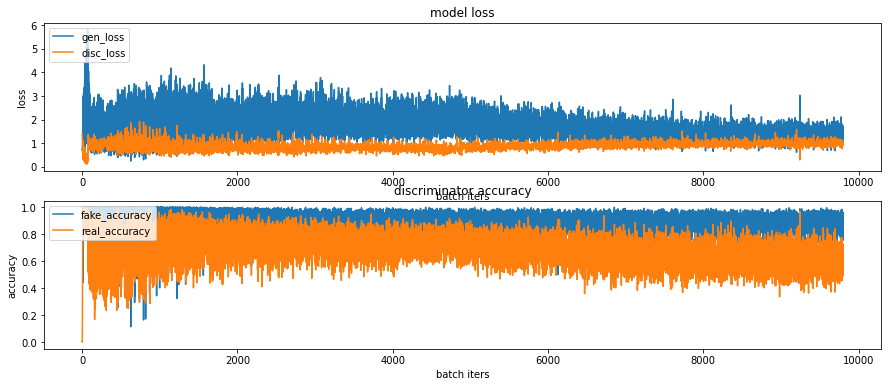

CPU times: user 20min 44s, sys: 1min 16s, total: 22min
Wall time: 20min 32s


In [95]:
%%time
train(train_dataset, EPOCHS, save_every)

In [96]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_01.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

ls: cannot access '/aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif': No such file or directory


## STEP 8. (optional) GAN 훈련 과정 개선하기 
>STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.  
모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.  

#### (참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것입니다.

- How to Train a GAN? Tips and tricks to make GANs work
- 10 Lessons I Learned Training GANs for one Year
- Tips for Training Stable Generative Adversarial Networks
- Improved Techniques for Training GANs(paper)

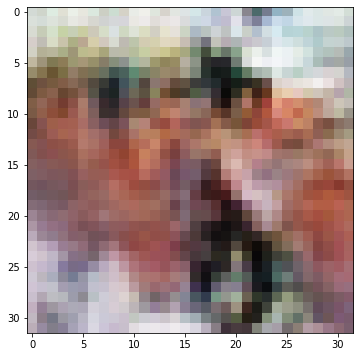

In [97]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### attempt 1. epoch = 100일 때

In [98]:
save_every = 5
EPOCHS = 100

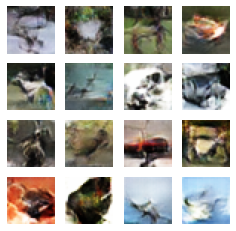

Time for training : 2483 sec


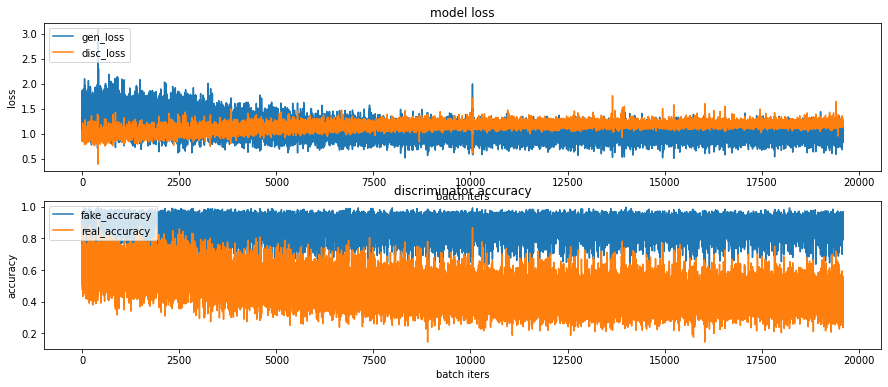

CPU times: user 41min 51s, sys: 2min 30s, total: 44min 21s
Wall time: 41min 24s


In [99]:
%%time
train(train_dataset, EPOCHS, save_every)

In [100]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_02.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

ls: cannot access '/aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif': No such file or directory


### attempt 2. adam optimizer의 learning rate를 2e-4로 설정

In [101]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

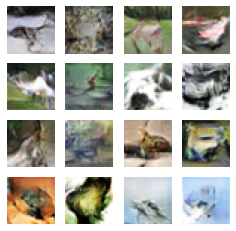

Time for training : 1247 sec


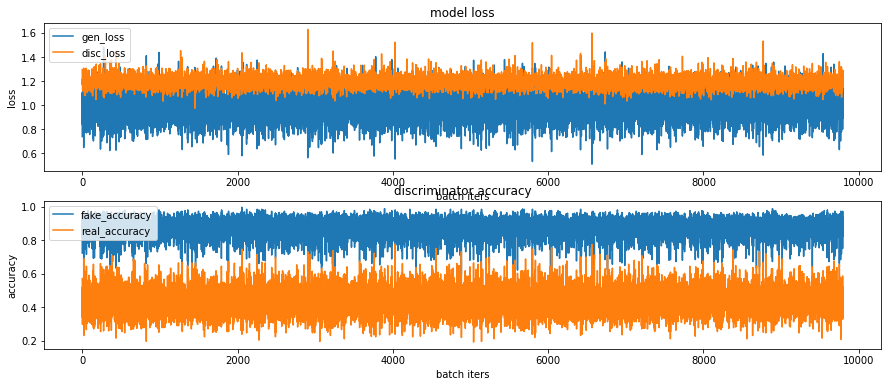

In [102]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

save_every = 5
EPOCHS = 50

train(train_dataset, EPOCHS, save_every)

In [103]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_04.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

ls: cannot access '/aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif': No such file or directory


### attempt 3. Batch size 256 -> 512로 늘리기

In [104]:
BATCH_SIZE = 512

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

save_every = 5
EPOCHS = 100

train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_05.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

## attempt 4. epoch = 500으로 늘리기

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

save_every = 5
EPOCHS = 500

train(train_dataset, EPOCHS, save_every)

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

save_every = 5
EPOCHS = 500

train(train_dataset, EPOCHS, save_every)

## 회고

1. 예전엔 노드를 진행할 때마다 이곳에 포함되어있는 모든 내용을 100% 소화하고자 하는 욕심을 냈었는데, 그러기보단 흐름 우주로 파악하고 어떤 모델이 있는지 살펴보면서 나의 관심 분야를 찾는 것을 목적으로 하기로 했다. 
2. 그래서 이번 노드도 100 + @를 하지 못해 아쉬움이 남지만 흐름을 이해하는데에는 크게 어려움이 없었다.
3. fake보다 real값에 더 가깝도록 모델을 만들기 위해 하이퍼 파라미터인 epoch, learning rate, batch size를 조정하는 시도를 해보았다. 
4. 찾아보니 Base GAN, Advanced GAN을 사용하는 방법도 있었는데,, 이후에 스터디에서 노드를 다시 볼 때 해보면 좋을 것 같다. 